In [11]:
Project = '/Users/daehwa/Library/CloudStorage/OneDrive-Personal/Junlab/Projects/Adipocyte'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.rcParams.update(plt.rcParamsDefault)

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

plt.rcParams['ps.useafm']=True
plt.rcParams['pdf.fonttype']=42

plt.rc('font', size=7)          # controls default text sizes
plt.rc('axes', titlesize=7)     # fontsize of the axes title
plt.rc('axes', labelsize=7)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=6)    # fontsize of the tick labels
plt.rc('legend', fontsize=6)    # legend fontsize
suptitlesize = 7

plt.rc('axes', axisbelow=True) #push axes to back
mpl.rcParams['axes.linewidth'] = 0.5
# plt.rcParams['axes.facecolor']='#E7E8E9'

---

In [12]:
MitoCarta3_file = '/Users/daehwa/Library/CloudStorage/OneDrive-Personal/Junlab/Data_Library/MITOCARTA3.0/Mouse.MitoCarta3.0.xls'
MitoCarta = pd.read_excel(MitoCarta3_file, 'A Mouse MitoCarta3.0')
MitoPW    = pd.read_excel(MitoCarta3_file, 'C MitoPathways')

name2ID = MitoCarta[['Symbol','EnsemblGeneID']].set_index('Symbol')['EnsemblGeneID'].to_dict()

MitoPW['PW level'] = MitoPW['MitoPathway Hierarchy'].str.split('>').str.len()
MitoPW['gene_ids'] = ''
for i in range(len(MitoPW)):
    for gene in MitoPW.iloc[i,:]['Genes'].split(', '):
        if type(name2ID[gene]) == float : continue
        MitoPW['gene_ids'][i] += name2ID[gene].replace('|',',') + ','
    MitoPW['gene_ids'][i] = MitoPW['gene_ids'][i][:-1]
MitoPW = MitoPW.set_index('MitoPathway',drop=True)

/var/folders/ct/z73cq4_j2g5612tltg_pmxxc0000gn/T/ipykernel_66836/3320499072.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MitoPW['gene_ids'][i] += name2ID[gene].replace('|',',') + ','
/var/folders/ct/z73cq4_j2g5612tltg_pmxxc0000gn/T/ipykernel_66836/3320499072.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MitoPW['gene_ids'][i] = MitoPW['gene_ids'][i][:-1]


In [13]:
Genesets = {
    'Mito. ribosome' : pd.DataFrame({'gene_id' : MitoPW.loc['Mitochondrial ribosome','gene_ids'].split(',')}),
    'Mito. ribosome assembly' : pd.DataFrame({'gene_id' : MitoPW.loc['Mitochondrial ribosome assembly','gene_ids'].split(',')}),
    # 'Translation factors' : pd.DataFrame({'gene_id' : MitoPW.loc['Translation factors','gene_ids'].split(',')}),
    'mt-rRNA modifications' : pd.DataFrame({'gene_id' : MitoPW.loc['mt-rRNA modifications','gene_ids'].split(',')}),
    'mt-tRNA modifications' : pd.DataFrame({'gene_id' : MitoPW.loc['mt-tRNA modifications','gene_ids'].split(',')}),
    'mt-tRNA synthetases' : pd.DataFrame({'gene_id' : MitoPW.loc['mt-tRNA synthetases','gene_ids'].split(',')}),
    'All MitoCarta' : MitoCarta[['EnsemblGeneID']].drop_duplicates().rename(columns={'EnsemblGeneID':'gene_id'}),
    'TCA cycle' : pd.DataFrame({'gene_id' : MitoPW.loc['TCA cycle','gene_ids'].split(',')}),
    'Fatty acid oxidation' : pd.DataFrame({'gene_id' : MitoPW.loc['Fatty acid oxidation','gene_ids'].split(',')}),
}

In [14]:
def strip_plot(x, y, width, s, c, lw, ax, rasterized):
    ax.scatter(list( x + (np.random.rand(1,len(y))[0] -0.5) * width ), y, 
                s=s, c=c, lw=lw,
                rasterized = rasterized,
                zorder=5)

---

In [15]:
RNA = pd.read_csv(f'{Project}/Results/Tables/CPM_RD_calculation/v20221217/adi_RNA_avg_log2FC.tsv', sep='\t').drop(columns='gene_name')
RPF = pd.read_csv(f'{Project}/Results/Tables/CPM_RD_calculation/v20221217/adi_RPF_avg_log2FC.tsv', sep='\t').drop(columns='gene_name')
PT = pd.read_csv(f'{Project}/Results/Tables/Proteome/PT_Norm_FC_calculation/v20240403/adi_PT_avg_log2FC.tsv', sep='\t')
PT_conv = pd.read_csv(f'{Project}/Results/Tables/Proteome/adi_proteome_logExp_geneid.tsv', sep='\t', usecols=('uniprot_id','gene_id'))
PT = pd.merge(PT_conv, PT, on='uniprot_id').drop(columns='uniprot_id').sort_values('gene_id').drop_duplicates(subset='gene_id')

logFC = {}
# logFC['R'] = RNA
# logFC['P'] = RPF
logFC['PT'] = PT

# display(logFC['R'],logFC['P'],logFC['PT'])

In [16]:
group_mem_n = len(Genesets)
group_gap = 0.5
x_pos = [i*(group_mem_n+group_gap) + j for i in range(len(logFC)) for j in range(len(Genesets))]
box_colors = ['#3DB7E9','#5EEFEB','#5EEFEB','#5EEFEB','#5EEFEB','#DDDDDD','#ECC2FF','#FFDBAB']
sct_colors = ['#006699','#399994','#399994','#399994','#399994','#88888855','#AA0DB4','#D55E00']
plot_data = []
for lib in logFC:
    for GS in Genesets:
        tmp = pd.merge(Genesets[GS], logFC[lib], on='gene_id')
        plot_data.append(list(tmp[f'{lib}8']))
box_color_list = box_colors*len(logFC)
sct_color_list = sct_colors*len(logFC)

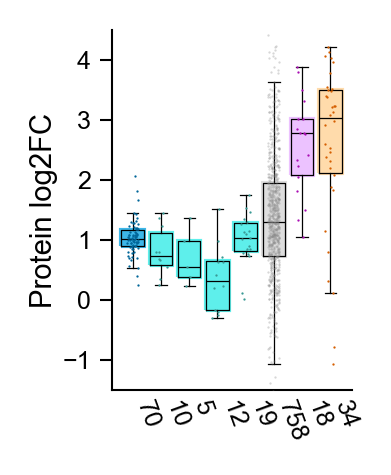

In [17]:
sF = 1 # Size factor
wgap = 0.1
hgap = 0.1
nrow, ncol = 1, 1

width_ratios = [0.8]
height_ratios = [1.2]

fs_w = sum(np.array(width_ratios)*sF) + (ncol-1)*wgap*sF
fs_h = sum(np.array(height_ratios)*sF) + (nrow-1)*hgap*sF

#
fig = plt.figure(figsize=( fs_w, fs_h ), dpi=300)
grid = plt.GridSpec(nrow, ncol,
                    width_ratios=width_ratios,
                    height_ratios=height_ratios,
                    wspace=wgap/np.average(width_ratios), 
                    hspace=hgap/np.average(height_ratios),
                    left=0, right=1, bottom=0, top=1)


ax = fig.add_subplot(grid[0,0])

box = ax.boxplot(plot_data, positions=x_pos, 
                 widths=0.8,
                 medianprops={'linewidth':0.3, 'color':'k'},
                 boxprops={'linewidth':0.3, 'color':'k'},
                 whiskerprops={'linewidth':0.3, 'color':'k'},
                 capprops={'linewidth':0.3, 'color':'k'},
                 showfliers=False,
                #  showmeans=True, meanprops={'marker':'D', 'markersize':'1.5', 'markerfacecolor':'k', 'markeredgewidth':0}
                 )
for artist, color in zip(box['boxes'], box_color_list):
    patch = mpl.patches.PathPatch(artist.get_path(), color=color)
    ax.add_artist(patch)

for x, values, c in zip(x_pos, plot_data, sct_color_list):
    rasterized = False
    if x == 5: rasterized = True
    strip_plot(x=x, y=values, 
               width=0.4, s=0.3, c=c, lw=0, 
               ax=ax, rasterized=rasterized)


ax.set_xlim(x_pos[0]-0.5-group_gap/2, x_pos[-1]+0.5+group_gap/2)
ax.set_ylim(-1.5, 4.5)
# ax.set_xticks([])
# ax.set_xticklabels([GS for GS in Genesets]*len(logFC), ha='left', rotation=-80)
ax.set_xticklabels([len(l) for l in plot_data], ha='left', rotation=-70)
ax.tick_params(width=0.5, length=3, pad=2)
ax.tick_params(axis='x', length=0, pad=2)

ax.set_xlabel('')
ax.set_ylabel('Protein log2FC', labelpad=1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)


plt.savefig('mitoTranslation_PTlogFC_box.pdf', bbox_inches='tight')
plt.show()
plt.clf()

In [18]:
from scipy.stats import mannwhitneyu, ks_2samp

print(mannwhitneyu(plot_data[0], plot_data[5]))
print(mannwhitneyu(plot_data[1], plot_data[5]))
print(mannwhitneyu(plot_data[2], plot_data[5]))
print(mannwhitneyu(plot_data[3], plot_data[5]))
print(mannwhitneyu(plot_data[4], plot_data[5]), '\n')
print(mannwhitneyu(plot_data[6], plot_data[5]))
print(mannwhitneyu(plot_data[7], plot_data[5]), '\n')

MannwhitneyuResult(statistic=19965.0, pvalue=0.0006064431500296325)
MannwhitneyuResult(statistic=2316.0, pvalue=0.03449945619754788)
MannwhitneyuResult(statistic=1028.5, pvalue=0.07790738225626959)
MannwhitneyuResult(statistic=1677.0, pvalue=0.00017342615492121303)
MannwhitneyuResult(statistic=5467.5, pvalue=0.07290181468552534) 

MannwhitneyuResult(statistic=11247.0, pvalue=2.509976007092077e-06)
MannwhitneyuResult(statistic=20196.0, pvalue=2.130845659879075e-08) 

